# ２-step Ttaining of VGG16
The 1st step is to carry out VGG16 transfer learning, and 2nd step to learn all layers including VGG16.
* Data overview
* Prepare train data
* Define the model (VGG16)
* Step1 : Training for the FC layers
* Step2 : Training all layers include VGG16
* Prepare test data & predict
* Submit

In [31]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

import cv2
from PIL import Image

#from sklearn.model_selection import train_test_split
#import itertools

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input

import random
import os

In [32]:
DIRin = "../input/"
DIRout = ""
print(os.listdir(DIRin))

['test', 'sample_submission.csv', 'train.csv', 'train']


## Data overview

In [33]:
trains = pd.read_csv(DIRin + "train.csv")
trains['has_cactus'] = trains['has_cactus'].astype(str)
trains.shape

(17500, 2)

In [34]:
trains.head(10)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


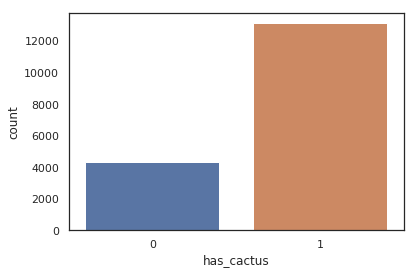

In [35]:
sns.countplot(trains.has_cactus)

In [36]:
trains.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [37]:
# For the test data, create a dataframe similar to 'trains'
tests = os.listdir(DIRin + 'test/test')
tests = pd.DataFrame(tests, columns=['id'])
tests['has_cactus'] = str(0.5)
tests.head()

,id,has_cactus
0,79ac4cc3b082e0a1defe1be601806efd.jpg,0.5
1,e880364d6521c6f3a27748ec62b0e335.jpg,0.5
2,74912492b6cdf28c4bfb9c8e1d35af3e.jpg,0.5
3,078cfa961183b30693ea2f13f5ff6d17.jpg,0.5
4,7fd729184ef182899ce3e7a174fb9bc0.jpg,0.5


In [38]:
#===== show_image(randum) =============
#    inS = "train"/"test"
#    inNum : number of display
#======================================
def show_image(inS = 'train', inNum = 10):
    if inS == 'train':
        df = trains
    else:
        df = tests
    fig = plt.figure(figsize=(10, inNum//5 * 2))
    for idx, img in enumerate(np.random.choice(df["id"], inNum)):
        ax = fig.add_subplot(inNum//5, 5, idx+1, xticks=[], yticks=[])
        im = Image.open(DIRin + inS + "/" + inS + "/" + img)
        plt.imshow(im)
        lab = df.loc[df['id'] == img, 'has_cactus'].values[0]
        ax.set_title(f'Label: {lab}')

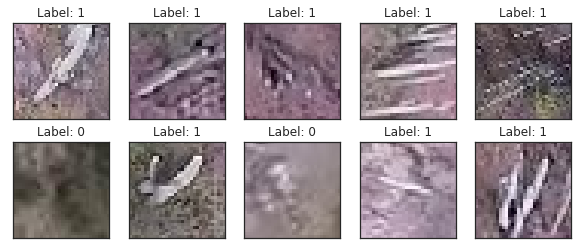

In [39]:
# sample images
show_image('train', 10)

## Prepare train data

In [40]:
# split train and val data
train_size = 14000
val_trains = trains[train_size:].copy()
val_trains = val_trains.reset_index(drop=True)

# train data
datagen=ImageDataGenerator(rescale=1./255)
X_train=datagen.flow_from_dataframe(dataframe = trains[:train_size],
                                      directory = DIRin + "train/train",
                                      x_col='id', y_col='has_cactus',
                                      batch_size=50,
                                      seed=42, shuffle=True,
                                      class_mode='binary',
                                      target_size=(32,32))
X_val=datagen.flow_from_dataframe(dataframe = val_trains,
                                    directory = DIRin + "train/train",
                                    x_col='id', y_col='has_cactus',
                                    batch_size=50,
                                    seed=42, shuffle=True,
                                    class_mode='binary',
                                    target_size=(32,32))

Found 14000 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


## Define the model (VGG16)

In [41]:
# base_model
base_model=VGG16(weights="imagenet",
                 include_top=False,
                 input_shape=(32,32,3))
base_model.trainable = False

base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [42]:
# Model construction
model = Sequential()
model.add(base_model)
    
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))
    
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, nesterov=True),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total para

Train only the FC layers.  so, number of trainable parameters is 165,121.

## Step1 : Training for the FC layers

In [44]:
# learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              patience=3,
                              verbose=1,
                              factor=0.5,
                              min_lr=1e-6)

In [45]:
epochs1 = 20
history1 = model.fit_generator(generator = X_train,
                              steps_per_epoch = X_train.n//X_train.batch_size,
                              epochs = epochs1,
                              validation_data = X_val,
                              validation_steps = X_val.n//X_val.batch_size,
                              verbose = 2,
                              callbacks = [reduce_lr])
# store model after training
model.save(DIRout+"temp.h5")

Epoch 1/20
 - 19s - loss: 0.4695 - acc: 0.7964 - val_loss: 0.2884 - val_acc: 0.9009
Epoch 2/20
 - 17s - loss: 0.2887 - acc: 0.9021 - val_loss: 0.2144 - val_acc: 0.9394
Epoch 3/20
 - 19s - loss: 0.2376 - acc: 0.9260 - val_loss: 0.1804 - val_acc: 0.9503
Epoch 4/20
 - 20s - loss: 0.2087 - acc: 0.9379 - val_loss: 0.1842 - val_acc: 0.9480
Epoch 5/20
 - 17s - loss: 0.1873 - acc: 0.9429 - val_loss: 0.1578 - val_acc: 0.9549
Epoch 6/20
 - 18s - loss: 0.1738 - acc: 0.9471 - val_loss: 0.1482 - val_acc: 0.9563
Epoch 7/20
 - 19s - loss: 0.1589 - acc: 0.9532 - val_loss: 0.1425 - val_acc: 0.9580
Epoch 8/20
 - 18s - loss: 0.1503 - acc: 0.9536 - val_loss: 0.1259 - val_acc: 0.9620
Epoch 9/20
 - 18s - loss: 0.1435 - acc: 0.9555 - val_loss: 0.1245 - val_acc: 0.9606
Epoch 10/20
 - 18s - loss: 0.1363 - acc: 0.9596 - val_loss: 0.1302 - val_acc: 0.9606
Epoch 11/20
 - 18s - loss: 0.1305 - acc: 0.9593 - val_loss: 0.1146 - val_acc: 0.9643
Epoch 12/20
 - 20s - loss: 0.1264 - acc: 0.9607 - val_loss: 0.1197 - val_a

([<matplotlib.lines.Line2D at 0x7f08c36c1048>,
 <matplotlib.legend.Legend at 0x7f08c36c1a90>)

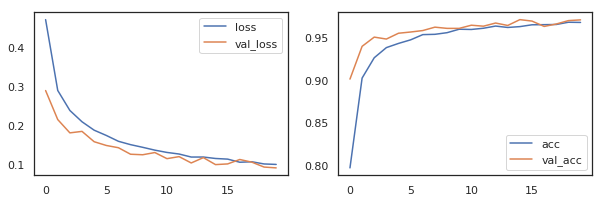

In [46]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1,2,figsize=(10, 3))

history_df1 = pd.DataFrame(history1.history)
ax[0].plot(history_df1[['loss', 'val_loss']]), ax[0].legend(['loss', 'val_loss'])
ax[1].plot(history_df1[['acc', 'val_acc']]), ax[1].legend(['acc', 'val_acc'])

In [47]:
# train data predict
datagen_p=ImageDataGenerator(rescale=1./255)
X_train_p=datagen_p.flow_from_dataframe(dataframe=trains,
                                   directory = DIRin + "train/train",
                                   x_col='id', y_col='has_cactus',
                                   batch_size=32, 
                                   seed=42, shuffle=False,
                                   class_mode=None,
                                   target_size=(32,32))

# ompare the predict value(pred_1) with the correct lavel(has_cactus)
P_train = model.predict_generator(X_train_p,
                                  steps = X_train_p.n//X_train_p.batch_size)
pred_1 = pd.DataFrame(P_train,columns=["pred_1"])
trains = pd.concat([trains, pred_1], axis = 1)
trains.head(10)

Found 17500 images.


,id,has_cactus,pred_1
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,0.96963
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,0.98521
2,000d1e9a533f62e55c289303b072733d.jpg,1,0.98811
3,0011485b40695e9138e92d0b3fb55128.jpg,1,0.99028
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,0.97331
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1,0.98315
6,002134abf28af54575c18741b89dd2a4.jpg,0,0.04826
7,0024320f43bdd490562246435af4f90b.jpg,0,0.21721
8,002930423b9840e67e5a54afd4768a1e.jpg,1,0.97163
9,00351838ebf6dff6e53056e00a1e307c.jpg,1,0.97944


## Step2 : Training all layers include VGG16
After training the FC layers appropriately, train all layers includ VGG16.

In [48]:
model=load_model(DIRout+"temp.h5")

model.trainable = True
model.compile(optimizer=SGD(lr=0.00005, momentum=0.9, nesterov=True),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total para

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Train all layers include VGG16.  so, Number of trainable parameters is 14,879,809.

In [49]:
epochs2 = 20
history2 = model.fit_generator(generator=X_train,
                              steps_per_epoch = X_train.n//X_train.batch_size,
                              epochs = epochs2,
                              validation_data = X_val,
                              validation_steps = X_val.n//X_val.batch_size,
                              verbose = 2,
                              callbacks = [reduce_lr])

Epoch 1/20
 - 21s - loss: 0.0785 - acc: 0.9763 - val_loss: 0.0497 - val_acc: 0.9854
Epoch 2/20
 - 18s - loss: 0.0458 - acc: 0.9879 - val_loss: 0.0446 - val_acc: 0.9891
Epoch 3/20
 - 20s - loss: 0.0372 - acc: 0.9899 - val_loss: 0.0326 - val_acc: 0.9906
Epoch 4/20
 - 19s - loss: 0.0295 - acc: 0.9928 - val_loss: 0.0326 - val_acc: 0.9889
Epoch 5/20
 - 19s - loss: 0.0221 - acc: 0.9950 - val_loss: 0.0297 - val_acc: 0.9909
Epoch 6/20
 - 19s - loss: 0.0214 - acc: 0.9952 - val_loss: 0.0294 - val_acc: 0.9926
Epoch 7/20
 - 21s - loss: 0.0207 - acc: 0.9954 - val_loss: 0.0267 - val_acc: 0.9934
Epoch 8/20
 - 19s - loss: 0.0176 - acc: 0.9962 - val_loss: 0.0280 - val_acc: 0.9943
Epoch 9/20
 - 19s - loss: 0.0145 - acc: 0.9973 - val_loss: 0.0221 - val_acc: 0.9929
Epoch 10/20
 - 19s - loss: 0.0151 - acc: 0.9974 - val_loss: 0.0231 - val_acc: 0.9931
Epoch 11/20
 - 20s - loss: 0.0122 - acc: 0.9979 - val_loss: 0.0204 - val_acc: 0.9943

Epoch 00011: ReduceLROnPlateau reducing learning rate to 2.49999993684468

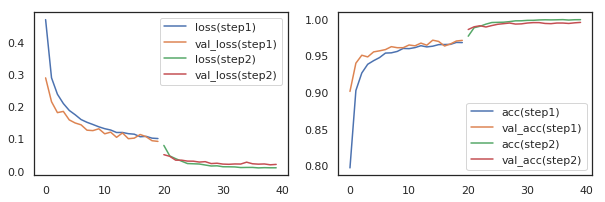

In [50]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1,2,figsize=(10, 3))

history_df2 = pd.DataFrame(history2.history)
history_df2.rename(index = lambda x: x+epochs1, inplace=True)
history_df2.rename(columns={'loss':'loss(step2)', 'acc':'acc(step2)',
                            'val_loss':'val_loss(step2)', 'val_acc':'val_acc(step2)'}, inplace=True)
history_df = pd.concat([history_df1,history_df2],sort=False)

ax[0].plot(history_df[['loss', 'val_loss','loss(step2)', 'val_loss(step2)']])
ax[0].legend(['loss(step1)', 'val_loss(step1)','loss(step2)', 'val_loss(step2)'])
ax[1].plot(history_df[['acc', 'val_acc','acc(step2)', 'val_acc(step2)']])
ax[1].legend(['acc(step1)', 'val_acc(step1)','acc(step2)', 'val_acc(step2)'])

In [51]:
# compare the predict value(pred_2) with the correct lavel(has_cactus)
P_train = model.predict_generator(X_train_p,
                                  steps = X_train_p.n//X_train_p.batch_size)
pred_2 = pd.DataFrame(P_train,columns=["pred_2"])
trains = pd.concat([trains, pred_2], axis = 1)
trains.head(10)

,id,has_cactus,pred_1,pred_2
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,0.96963,0.99403
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,0.98521,0.99949
2,000d1e9a533f62e55c289303b072733d.jpg,1,0.98811,0.99453
3,0011485b40695e9138e92d0b3fb55128.jpg,1,0.99028,0.99441
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,0.97331,0.99624
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1,0.98315,0.99806
6,002134abf28af54575c18741b89dd2a4.jpg,0,0.04826,0.00001
7,0024320f43bdd490562246435af4f90b.jpg,0,0.21721,0.00011
8,002930423b9840e67e5a54afd4768a1e.jpg,1,0.97163,0.99381
9,00351838ebf6dff6e53056e00a1e307c.jpg,1,0.97944,0.99630


## Prepare test data & Predict

In [52]:
# test data
testgen=ImageDataGenerator(rescale=1./255)
X_test=testgen.flow_from_dataframe(dataframe=tests,
                                   directory = DIRin + "test/test",
                                   x_col='id', y_col='has_cactus',
                                   batch_size=32, 
                                   seed=42, shuffle=False,
                                   class_mode=None,
                                   target_size=(32,32))

Found 4000 images.


In [53]:
# predict
P_test = model.predict_generator(X_test,
                                 steps=X_test.n//X_test.batch_size)

In [57]:
tests['pred'] = P_test
tests['has_cactus'] = tests['pred'].apply(lambda x: 1 if x > 0.5 else 0)
tests.head(15)

,id,has_cactus,pred
0,79ac4cc3b082e0a1defe1be601806efd.jpg,1,0.97709
1,e880364d6521c6f3a27748ec62b0e335.jpg,1,0.99642
2,74912492b6cdf28c4bfb9c8e1d35af3e.jpg,1,0.99684
3,078cfa961183b30693ea2f13f5ff6d17.jpg,1,0.98242
4,7fd729184ef182899ce3e7a174fb9bc0.jpg,1,0.99656
5,2b5f23aba5af7bdffa13d7fc87cfd704.jpg,1,0.99465
6,56252603457e38c4b9d539d6a3be380d.jpg,1,0.99184
7,3a5657d140458ae32c2780818b51a0b2.jpg,1,0.99760
8,1bf2e11a8d218c3795202270a942705c.jpg,1,0.99700
9,60515ac7f73add1c96f360b21f45a944.jpg,0,0.00000


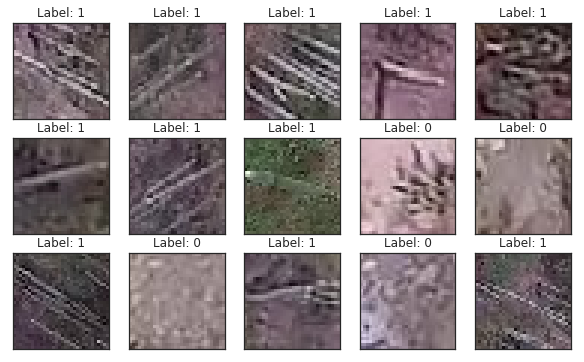

In [55]:
# predicted sumple
show_image('test', 15)

## Submit

In [56]:
submit = tests.drop("pred", axis=1)
submit.to_csv(DIRout + 'solution_01.csv', index=False)